In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
from glob import glob
from scipy.optimize import curve_fit
from scipy.constants import Planck
from scipy.constants import speed_of_light
from scipy.constants import Boltzmann
from scipy.constants import Avogadro

In [6]:
#defining laserintensity
def I_r():
    return 2*(powerx+powery+powerz)/(np.pi*omega**2)

#defining solid angle theta for conversion
def theta():
    return radius**2/(4*distance**2)

#defining scatteringRate for conversion
def scatteringRate():
    I_0 = I_r()
    resultScatteringRate = 1e6*(lw/2)*(I_0/I_sat)/(1+I_0/I_sat+4*detuning**2/lw**2)
    return resultScatteringRate

#defining wavelength with detuning for conversion
def wavelength():
    return speed_of_light/(sp_85-sf3_85+(pf4_85-pf2_85)/2-detuning*1e6)
#KEEP IN MIND: value is taken from second explanation on page 68 from F20.pdf

#defining energy from a phton with wavelength(detuning) for conversion
def energy():
    return Planck*speed_of_light/wavelength()

#translating voltage into #atoms
def conversion(voltage):
    scat = scatteringRate()
    eng = energy()
    angle = theta()
    natoms = voltage/(QE*G*S*Trans*angle*scat*eng)
    return natoms

#defining fit fuction for Temperature with Capture and Release methode
def capReal(x,T):
    chi = np.sqrt(M/(Boltzmann*T))*R*1e3/x
    result = np.erf(chi)-(2/np.pi**0.5)*chi*np.exp(-chi**2)
    return result
    
#reading out the csv and returning time and voltage as arrays
def grabPart3(offtime):
    #offtime is an int specifying the time the trap was turn off
    #creating path without knowledge of number of .csv
    path='Part III/Off_'+str(offtime)+'/F*CH1.csv'
    #looking for the number of the .csv in the corresponding folder
    file = glob(path)[0]
    #reading the .csv
    dg = np.genfromtxt(file, delimiter=',')
    #6 dim array with most of them being 'empty' caused by the way Oscilloscope writes the .csv
    #Example of the first 3 'lines', column 0 and 1 become NaN as well after 17 lines
#                   0                   1   2      3     4   5
#0        Record Length        2.500000e+03 NaN  0.000  3.04 NaN
#1      Sample Interval        1.000000e-03 NaN  0.001  3.02 NaN
#2        Trigger Point  0.000000000000e+00 NaN  0.002  3.02 NaN
    #splitting the csv columns in 6 arrays from which we only want time and voltage
    g0,g1,g2,g3,g4,g5 = np.hsplit(dg,6)
    #g3=time, g4=voltage
    return g3,g4

In [3]:
I_sat=4.1 #mW/cm^2, Saturation Intensity taken from F20.pdf page 82
lw=2*np.pi*6.07 #MHz, Natural Line Width of RB 85 (what about 87?) taken from F20.pdf page 82
Trans=0.96 #a.u., Transmission of the optical viewport taken from F20.pdf page 83
radius=25.4 #mm, radius of the collecting lense taken from F20.pdf page 83
distance=150 #mm, distance between MOT and Photodiode taken from F20.pdf page 83
R=0.015 #m, radius of the MOT taken from F20.pdf page 82
M=85.46783/Avogadro #kg,Standard Atommass of Rubidium (72.17% RB85, 27.83% RB87) taken from Wikipedia
G=4.75e6 #V/A, Gain of Photdiode amplifier at +70dB taken from F20.pdf page 83
Gf=G*0.05 #V/A, Error of G taken from F20.pdf page 83
QE=0.52 #A/W, Quantum Efficiency of the sensor taken from F20.pdf page 83
QEf=0.015 #A/W, Error of QE taken from F20.pdf page 83
S=1e6/(1e6+50) #a.u., Scale Factor cause by impedance difference taken from F20.pdf page 83
sp_85=384.230406373e12 #Hz, S->P transition for RB85 taken from F20.pdf page 19
sf3_85=1.264888e9 #Hz, deltaF in S for F=3 for RB85 taken from F20.pdf page 19
pf2_85=83.835e6 #Hz, deltaF in P for F=2 for RB85 taken from F20.pdf page 19
pf4_85=100.205e6 #Hz, deltaF in P for F=4 for RB85 taken from F20.pdf page 19
detuning=8.5 #Mhz, yajie's suggestion (isn't mentioned in lab book anywhere)
powerx=8 #mW, Laserpower in x direction
powery=8 #mW, Laserpower in y direction
powerz=18 #mW, Laserpower in z direction
omega=0.2 #cm, width of Laser Beam taken from F20.pdf page 83
approx=0.043 #V, taken from Part II
#array which contains the values of 'offtime'
off=([1,2,3,4,5,7,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,30,35,40,45,60])

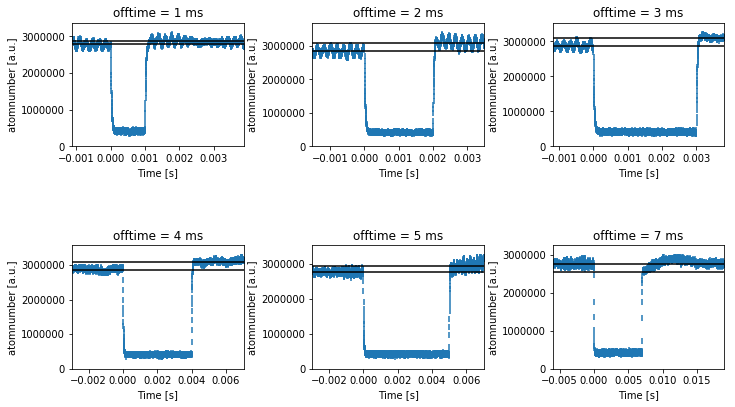

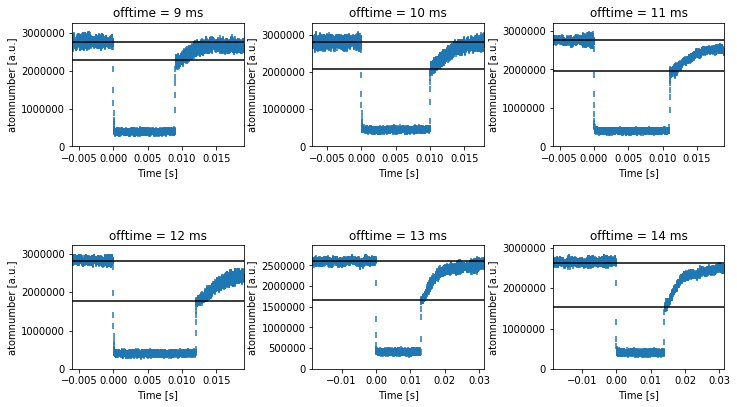

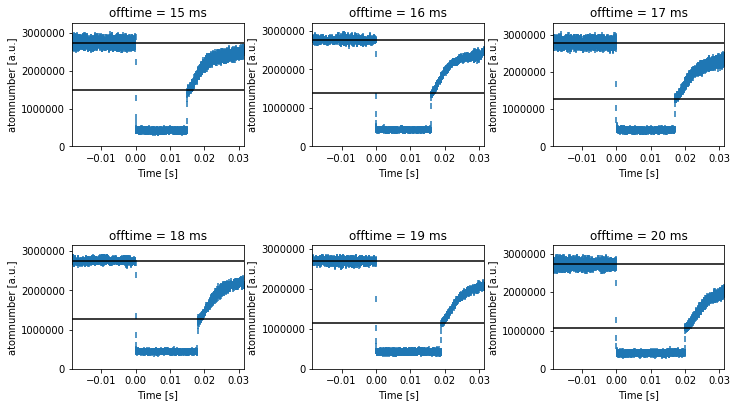

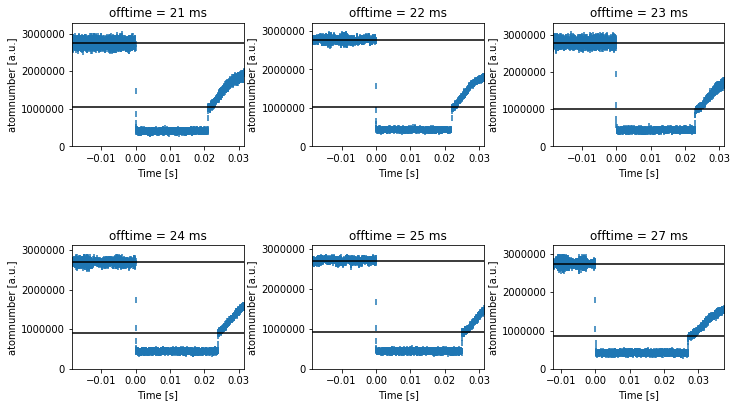

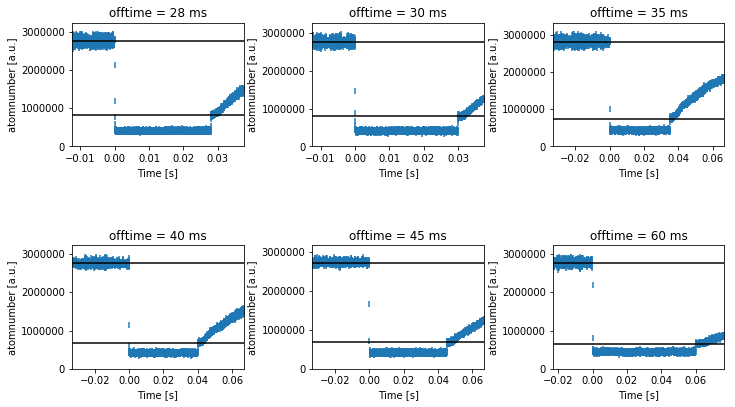

In [4]:
n0_mean=np.empty((np.size(off),2))
n1_mean=np.empty((np.size(off),2))
n_back=np.empty((np.size(off),2))
t_d=([])
#print('DATA | LABBOOK')
for i in enumerate(off):
    if i[0]==0: j=1
    delay = i[1]
    t,u = grabPart3(delay)
    #some delays seem to be wrongly recorded in our labbook -> 1 ms less each
    if delay in [17,18,19,20,21,22,23,24,25,26]: delay=delay-1
    #use turn off point is at t=0s for n0
    t_off=-0.0005
    u_mod0=u[np.where(t < t_off)]
    t_mod0=t[np.where(t < t_off)]
    #different conversion, uses a set detuning 
    n0_mod=conversion(u_mod0)
    #use turn on point is at t=0s+i[1]/1000
    t_on=delay/1000+0.0001
    u_mod1=u[np.where(t > t_on)]
    t_mod1=t[np.where(t > t_on)]
    #differencing between n0 = n1 and n0 =/= n1
    if i[1] in [14]:
        n1_mod=conversion(u_mod1[:1])
    elif i[0] > 4 :
        n1_mod=conversion(u_mod1[:7])
    else :
        n1_mod=conversion(u_mod1)
    #rough background estimation, without taking laserlight into account
    t_back=([0.0003,t_on-0.003])
    t_mod2=t[np.where(u<0.04)]
    u_mod2=u[np.where(t > t_back[0])]
    u_mod3=u[np.where(u<0.04)]
    nb_mod=conversion(u_mod3)
    #could also use Part II approximation for background from laser -> 0.0524 +/- 0.0017
    #filling final lists
    n0_mean[i[0]]=np.mean(n0_mod),np.std(n0_mod)
    n1_mean[i[0]]=np.mean(n1_mod),np.std(n1_mod)
    n_back[i[0]]=np.mean(nb_mod),np.std(nb_mod)
    t_d.append(delay)
    #drawing the subplots of just data while leaving "error" signals below 0.025V out 
    un=conversion(u)
    plt.subplot(2,3,j)
    plt.scatter(t,un,marker="|") 
    plt.hlines(n0_mean[i[0],0],-10,10)
    plt.hlines(n1_mean[i[0],0],-10,10)
    plt.xlim(t[0],t[-1])
    ymax=np.amax(un)*1.1
    plt.ylim(0.01,ymax)
    plt.xlabel('Time [s]')
    plt.ylabel('atomnumber [a.u.]')
    plt.title('offtime = '+str(delay)+' ms')
    #every 8 subplots = 1 picture
    j=j+1
    if(j>6): 
        plt.subplots_adjust(wspace=0.4,hspace=0.8)
        plt.gcf().set_size_inches(11.69, 8.27/1.3)
        plt.show()
        j=1
    #t_off=t[np.where(u<0.04)]
    #print(str(np.round(t_off[-1]-t_off[0],3))+'|'+str(i[1]/1000))
    #del t_off
    #clean up    
    del t,u,un,delay,t_on,t_off,t_back,n0_mod,n1_mod,nb_mod
    del u_mod0,t_mod0,u_mod1,t_mod1,u_mod2,t_mod2,u_mod3

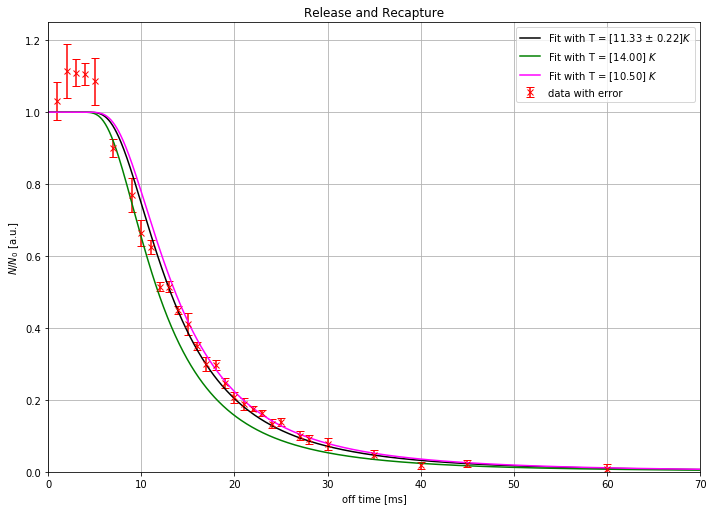

In [17]:
#Capture and Release Scatter and Fit 
#calaculating ratio N(t)/N(0) with subtracting better background esimation
#better background estimation WITH laser from Part II -> V_out = 0.0524 +/- 0.0017
n_b=conversion(0.0524)
n_bf=conversion(0.0017)
np.seterr(divide='ignore', invalid='ignore') #ignoring Runtimewarning
ratio = (n1_mean[:,0]-n_b)/(n0_mean[:,0]-n_b)
ratio_f = np.sqrt((n1_mean[:,1]/(n0_mean[:,0]-n_b))**2+
                  ((n1_mean[:,0]-n_b)*n0_mean[:,1]/(n0_mean[:,0]-n_b)**2)**2+
                  ((n1_mean[:,0]-n_b)*n_bf/(n0_mean[:,0]-n_b)**2)**2)
#making the fit for Relase and Capture
i=0 #values left out at the start
j=-1 #left values at the end
temp, tempf = curve_fit(capReal,t_d[i:j],ratio[i:j],sigma=ratio_f[i:j],bounds=(1e-10,500)) 
#scattering taken datapoints
x=np.linspace(0,70,1000)
plt.errorbar(t_d,ratio,yerr=ratio_f,fmt='rx',capsize=4,label='data with error')
plt.plot(x,capReal(x,*temp),'k',label='Fit with T = ['+str(np.round(temp[0],2))+' $\pm$ '+
        str(np.round(np.sqrt(tempf[0][0]),2))+']$ K$')
plt.plot(x,capReal(x,14),color='green',label='Fit with T = [14.00] $ K$')
plt.plot(x,capReal(x,10.5),color='magenta',label='Fit with T = [10.50] $ K$')
#cosmetics
plt.xlabel('off time [ms]')
plt.ylabel('$N/N_{0}$ [a.u.]')
plt.legend(loc='upper right')
plt.xlim(0,70)
plt.ylim(0,1.25)
plt.grid(True)
plt.title('Release and Recapture')
plt.gcf().set_size_inches(11.69, 8.27)
plt.show()